# Prepare a Training Data Set for ML

The main goal of this tutorial is to: Extract data from **multiple** STAC collections only at the **specified locations**. 

As an example use case we are going to...
- download point data time series with a measured variable (e.g. snow depth)
- query a STAC catalog to get acquisitions for the points in the relevant time frame (temporal, spatial)
- load the found items into one data cube, by only loading the relevant geometry
- homogenize the datacube to a common temporal and spatial resolution
- calculate the NDSI (*ideally the collections should be radiometrically harmonized, e.g. [sen2like](https://github.com/senbox-org/sen2like), we are not doing this for this tutorial*)
- evaluate the gain in time steps 
- convert the data cube and the station measurements into a format that can be used for machine learning
- regression model to predict snow depth (this is exemplatory, not scientifically valid)

This tutorial should serve as guidance on how to extract data from multiple sources from STAC catalogs and use them in further workflows.
There are many more applications that could be covered. The next step could be to add more predictors and do a a multivariate regression, taking into account more factors like elevation, aspect, temperature, etc.

Things to consider
- sparse xarray data cubes
- xvec
- polytope

## Environment

 This notebook can be run in the micromamba default Environment or you can create your own user Environment (called tutorialEnv in the example) using:
 
`!micromamba install -y -n tutorialEnv jupyter xarray rioxarray odc-stac odc-geo pystac-client dask folium geopandas zarr jupyter-server-proxy`

and then starting a new Jupyter Environment from the portal specifying the Name of your newly created env in the  custom Environment Field

In [1]:
#!micromamba install -y -n tutorialEnv jupyter xarray rioxarray odc-stac odc-geo pystac-client dask folium geopandas zarr jupyter-server-proxy

In [76]:
import os
import time
import socket
import io
import requests
import zipfile
import pandas as pd
import geopandas as gpd
import numpy as np

import xarray
import rioxarray
from shapely.geometry import box, shape
from odc import stac as odc_stac
from odc.geo import geobox
from pystac_client import Client as pystacclient
import dask
from dask.distributed import Client

import folium
import folium.plugins as folium_plugins
import branca.colormap as cm

## Download station data

Download station data time series. We are going to use monthly snow depth measurements in South Tyrol. They have been prepared, gapfilled and made available via the ClirSnow project.

In [2]:
# set url
url = 'https://zenodo.org/records/5109574/files/meta_all.csv?download=1'
filename = url.split('/')[-1]
filename = filename.split('?')[0]

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the file locally
    with open(filename, 'wb') as file:
        file.write(response.content)
    print("File downloaded and saved successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and saved successfully.


In [3]:
sd_meta = pd.read_csv(filename)
sd_meta.head()

,Provider,Name,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end
0,AT_HZB,Absdorf,15.976667,48.401667,182.0,1970.0,2016.0,1970.0,2016.0
1,AT_HZB,Ach_Burghausen,12.846389,48.148889,473.0,1990.0,2016.0,1990.0,2016.0
2,AT_HZB,Admont,14.457222,47.567778,700.0,1970.0,2016.0,1970.0,2016.0
3,AT_HZB,Afritz,13.795556,46.727500,715.0,1970.0,2016.0,1970.0,2016.0
4,AT_HZB,Alberschwende,9.849167,47.458333,717.0,1982.0,2016.0,1982.0,2016.0


In [4]:
# set url
url = 'https://zenodo.org/records/5109574/files/data_monthly_IT_BZ.zip?download=1'
filename = url.split('/')[-1]
filename = filename.split('?')[0]

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the downloaded file as a zip file
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        # Extract all contents into the current directory
        zip_ref.extractall()
    print("File downloaded and extracted successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and extracted successfully.


In [5]:
# read it into memory
filename = filename.split('.')[0] + '.csv'
sd_mnth = pd.read_csv(filename)
sd_mnth.head()

,Name,year,month,HNsum,HSmean,HSmax,SCD1,SCD1gt,SCD10,SCD20,...,HSmean_gapfill,frac_gapfilled,HSmax_gapfill,SCD1_gapfill,SCD1gt_gapfill,SCD10_gapfill,SCD20_gapfill,SCD30_gapfill,SCD50_gapfill,SCD100_gapfill
0,Alliz_Maso_Strimo_Osservatore,1991,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.612903,1.0,54.0,31.0,31.0,31.0,31.0,31.0,6.0,0.0
1,Alliz_Maso_Strimo_Osservatore,1991,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.392857,1.0,48.0,28.0,28.0,28.0,28.0,28.0,0.0,0.0
2,Alliz_Maso_Strimo_Osservatore,1991,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.677419,1.0,29.0,28.0,28.0,21.0,13.0,0.0,0.0,0.0
3,Alliz_Maso_Strimo_Osservatore,1991,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.366667,1.0,6.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0
4,Alliz_Maso_Strimo_Osservatore,1991,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.032258,1.0,8.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0


## Prepare station data

Filter the metadata to keep only stations form the province of South Tyrol having values between 2000 and 2019. 

In [6]:
start = 2000
end = 2019
sd_meta = sd_meta[(sd_meta['Provider'] == 'IT_BZ') & (sd_meta['HS_year_start'] <= start) & (sd_meta['HS_year_end'] >= end)]
sd_meta = sd_meta[['Name', 'Longitude', 'Latitude', 'Elevation']]

Select relevant columns.

In [7]:
sd_mnth = sd_mnth[['Name', 'year', 'month', 'HSmean_gapfill']]
sd_mnth = sd_mnth[sd_mnth['year'].between(start, end)]

And join the meta data (geographical information, ...).

In [8]:
sd = pd.merge(sd_meta, sd_mnth, on='Name', how='inner')

This is what our station data looks like now. The meta data combined with the measurements.

In [9]:
sd.head()

,Name,Longitude,Latitude,Elevation,year,month,HSmean_gapfill
0,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,1,21.258065
1,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,2,18.103448
2,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,3,7.935484
3,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,4,0.033333
4,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,5,0.000000


Turn snow depth tune series into a geodataframe (we also do it for the metadata for plotting the locations).

In [10]:
sd = gpd.GeoDataFrame(sd, geometry=gpd.points_from_xy(sd.Longitude, sd.Latitude), crs="EPSG:4326")
sd_meta = gpd.GeoDataFrame(sd_meta, geometry=gpd.points_from_xy(sd_meta.Longitude, sd_meta.Latitude), crs="EPSG:4326")

Create a buffer around the points for extracting more than just one pixel.

In [11]:
sd_meta = sd_meta.to_crs(3035) # LAEA Europe
sd_meta['geometry'] = sd_meta['geometry'].buffer(distance=200, cap_style='square') # square
sd_meta = sd_meta.to_crs(4326) # Back to 4326

Look at the distribution of the stations and the buffers on a map.

In [101]:
colormap = cm.linear.viridis.scale(round(sd_meta['Elevation'].min(), -2), round(sd_meta['Elevation'].max(), -2))
colormap.caption = 'Elevation m'

m = folium.Map(tiles="OpenStreetMap", zoom_start=9)

folium.GeoJson(
    sd_meta,
    name="Snow Depth Stations Buffer",
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['Elevation']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=["Name", "Elevation"]),
).add_to(m)

folium.GeoJson(
    sd_meta.geometry.centroid,
    name="Snow Depth Stations",
).add_to(m)

colormap.add_to(m)
m.fit_bounds(m.get_bounds())
m

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_35918/4200203065.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_meta.geometry.centroid,


Create a bounding box columns for querrying the STAC catalog.

In [13]:
#sd_meta['bbox'] = '['+sd_meta.bounds.astype(str)[["minx", "miny", "maxx", "maxy"]].apply(",".join, axis=1)+']'
sd_meta = pd.concat([sd_meta, sd_meta.bounds], axis=1)

# Explore the STAC catalog

In [14]:
catalog_url = 'https://stac.terrabyte.lrz.de/public/api'
catalog = pystacclient.open(catalog_url)
collections = list(catalog.get_all_collections())
for collection in collections:
    print(f"{collection.id} | {collection.title}")

modis-09gq-061 | MOD09GQ.061 & MYD09GQ.061: MODIS Surface Reflectance Daily (250m)
viirs-13a1-001 | VNP13A1.001: VIIRS Vegetation Indices 16-Day (500m)
modis-13q1-061 | MOD13Q1.061 & MYD13Q1.061: MODIS Vegetation Indices 16-Day (250m)
sentinel-2-c1-l1c | Sentinel-2 Collection 1 Level-1C
sentinel-1-grd | Sentinel-1 GRD Level-1
sentinel-1-slc | Sentinel-1 SLC Level-1
modis-13a2-061 | MOD13A2.061 & MYD13A2.061: MODIS Vegetation Indices 16-Day (1km)
sentinel-3-olci-l1-efr | Sentinel-3 OLCI Level-1 EFR
viirs-09ga-001 | VNP09GA.001: VIIRS/NPP Surface Reflectance Daily L2GD 500m and 1km
landsat-tm-c2-l2 | Landsat 4-5 TM Collection 2 Level-2
landsat-etm-c2-l2 | Landsat 7 ETM+ Collection 2 Level-2
cop-dem-glo-90 | Copernicus DEM GLO-90
cop-dem-glo-30 | Copernicus DEM GLO-30
sentinel-2-l1c | Sentinel-2 Level-1C
sentinel-1-nrb | Sentinel-1 Normalized Radar Backscatter (NRB)
landsat-ot-c2-l2 | Landsat 8-9 OLI/TIRS Collection 2 Level-2
sentinel-2-c1-l2a | Sentinel-2 Collection 1 Level-2A
viirs-15a2

Check the bandnames for S2 C1 L2A and the LS collections

In [58]:
collections[16]

<CollectionClient id=sentinel-2-c1-l2a>

# Query data from the STAC catalog

## Query a single station

Let's define the parameters we want to use for both collections.

In [16]:
max_cloud_cover = 25

query = {
    'eo:cloud_cover': {
        "gte": 0,
        "lte": max_cloud_cover
    }
}

start = '2000-01-01T00:00:00Z'
end = '2019-12-31T23:59:59Z'

bands = ['swir16', 'green'] # luckily the bands have the same names across multiple collections.

Search Sentinel-2 for one specific station.

In [89]:
%%time
collection = ['sentinel-2-c1-l2a']
bbox = [sd_meta.minx.iloc[0], sd_meta.miny.iloc[0], sd_meta.maxx.iloc[0], sd_meta.maxy.iloc[0]]

search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items = list(search.items()) # TO DO: Is this still the correct way to do it?

print(f'Found {len(items)} Scenes') 

Found 81 Scenes
CPU times: user 63.7 ms, sys: 15.4 ms, total: 79 ms
Wall time: 932 ms


Inspect the search results. Full tiles are returned with their according metadata.

In [63]:
items[0]

<Item id=S2A_MSIL2A_20191230T101421_N0500_R022_T32TQT_20230619T224243>

Search Sentinel-2 and all Landsat collections for the specified parameters and the same specific station.

In [90]:
%%time
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2', 'sentinel-2-c1-l2a']

search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items = list(search.items()) # TO DO: Is this still the correct way to do it?

print(f'Found {len(items)} Scenes') 

Found 1088 Scenes
CPU times: user 819 ms, sys: 74.1 ms, total: 894 ms
Wall time: 18.8 s


In [91]:
%%time
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2', 'sentinel-2-c1-l2a']

for col in collection: 
    search = catalog.search(collections=col,
                            bbox=bbox,
                            datetime=[start, end],
                            query=query)
    items = list(search.items()) # TO DO: Is this still the correct way to do it?
    print(f'Collection: {col}. Found {len(items)} Scenes') 

Collection: landsat-ot-c2-l2. Found 154 Scenes
Collection: landsat-etm-c2-l2. Found 568 Scenes
Collection: landsat-tm-c2-l2. Found 285 Scenes
Collection: sentinel-2-c1-l2a. Found 81 Scenes
CPU times: user 1.69 s, sys: 56.4 ms, total: 1.75 s
Wall time: 15 s


## Query multiple stations

Define a function to use to iterate over all stations. bbox is the variable object.

In [87]:
def query_stac(row):
    bbox = [row.minx, row.miny, row.maxx, row.maxy]
    search = catalog.search(collections=collection,
                            bbox=bbox,
                            datetime=[start, end],
                            query=query)
    items = list(search.items())
    print(f"Name: {row['Name']}, Items: {len(items)}")
    return items

The function is applied to the station metadata geodataframe, where we had stored the buffers around the stations. The result is a list with all found STAC items for each of the stations.

In [94]:
collection = ['sentinel-2-c1-l2a']
items_list = sd_meta.apply(query_stac, axis=1)

Name: Anterselva_di_Mezzo_Osservatore, Items: 81
Name: Bronzolo_Osservatore, Items: 26
Name: Diga_di_Gioveretto_Osservatore, Items: 26
Name: Diga_di_Neves_Osservatore, Items: 115
Name: Diga_di_Valdaora_Osservatore, Items: 14
Name: Diga_di_Vizze_Osservatore, Items: 158
Name: Diga_di_Zoccolo_Osservatore, Items: 26
Name: Fie_allo_Sciliar_Osservatore, Items: 26
Name: Fontana_Bianca, Items: 26
Name: Fortezza_Osservatore, Items: 50
Name: Fundres_Osservatore, Items: 304
Name: La_Villa_in_Badia_Osservatore, Items: 14
Name: Lago_Verde_Osservatore, Items: 26
Name: Lazfons_Osservatore, Items: 26
Name: Longiaru_Osservatore, Items: 14
Name: Luson_Osservatore, Items: 14
Name: Maia_Alta_Osservatore, Items: 26
Name: Mazia_Osservatore, Items: 26
Name: Melago_Osservatore, Items: 26
Name: Meltina_Osservatore, Items: 26
Name: Molini_di_Tures_Osservatore, Items: 81
Name: Ortisei_Osservatore, Items: 29
Name: Pennes_Osservatore, Items: 26
Name: Plata_Osservatore, Items: 26
Name: Racines_di_Dentro_Osservatore

## Use the geoemetry of interest

So far we get the full tiles. But we are only interested in small regions of full tiles. We'll add the geometry to the query so that we have it availalbe when loading the data later on.

In [95]:
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2', 'sentinel-2-c1-l2a']
bbox = [sd_meta.minx.iloc[0], sd_meta.miny.iloc[0], sd_meta.maxx.iloc[0], sd_meta.maxy.iloc[0]]

filtered_items = []
search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items = list(search.items()) # TO DO: Is this still the correct way to do it?
# TO DO: Trying to get the geoms of sd_meta and the items in a list together so that they can be used for loading later on.
for item in items:
    filtered_items.append({
        'item': item,
        'station': bbox
    })

#print(f'Found {len(items)} Scenes') 
print(f'Found {len(filtered_items)} Scenes') 


Found 1088 Scenes


Now we have the STAC item togehter with our area of interest.

In [99]:
print(filtered_items[0])
print(filtered_items[2])

{'item': <Item id=S2A_MSIL2A_20191230T101421_N0500_R022_T32TQT_20230619T224243>, 'station': [12.098205461090107, 46.8588708999981, 12.103587999028658, 46.862572630581994]}
{'item': <Item id=LC08_L2SP_192028_20191226_20200824_02_T1>, 'station': [12.098205461090107, 46.8588708999981, 12.103587999028658, 46.862572630581994]}


Let's plot a tile in relation to a station

In [110]:
map = folium.Map()
layer_control = folium.LayerControl(position='topright', collapsed=True)

tile_s2 = shape(filtered_items[0]['item'].geometry)
tile_s2 = gpd.GeoDataFrame([{'geometry': tile_s2}], crs="EPSG:4326")
tile_s2 = folium.GeoJson(tile_s2.to_json(), name="S2", style_function=lambda x: {"fillColor": "blue"})

tile_ls = shape(filtered_items[2]['item'].geometry)
tile_ls = gpd.GeoDataFrame([{'geometry': tile_ls}], crs="EPSG:4326")
tile_ls = folium.GeoJson(tile_ls.to_json(), name="LS", style_function=lambda x: {"fillColor": "green"})

station = box(*filtered_items[0]['station'])
station = gpd.GeoDataFrame({"geometry": [station]}, crs="EPSG:4326")
station_mark = station.geometry.centroid
station = folium.GeoJson(station.to_json(), name="Station", style_function=lambda x: {"fillColor": "red"})

station_mark = folium.GeoJson(station_mark,name="Station Marker")

tile_s2.add_to(map)
tile_ls.add_to(map)
station.add_to(map)
station_mark.add_to(map)
layer_control.add_to(map)
map.fit_bounds(map.get_bounds())
map

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_35918/891336458.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  station_mark = station.geometry.centroid


## Load the search results

As we've seen in the map above, it is very important to include the geometry of interest when we load the data. 

In [138]:
filtered_items[0]['item']

<Item id=S2A_MSIL2A_20191230T101421_N0500_R022_T32TQT_20230619T224243>

In [ ]:
Let's load the data together with their according geometries from the data structure we have created beforehand.

In [115]:
cube = odc_stac.load(filtered_items[:][0].item, # i want the list of all links here
                     geopolygon=sd_meta.iloc[0].geometry, # i want the according geoms here
                     groupby='solar_day',
                     #bbox=sd_meta.iloc[1:2],
                     #chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
                     #anchor=geobox.AnchorEnum.FLOATING,  # preserve original pixel grid
                     bands=bands
)
cube

AttributeError: 'dict' object has no attribute 'item'

Get the according geometry to load only the area we are interested in.

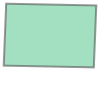

In [69]:
sd_meta.iloc[0].geometry

Load the items into a data cube. 

In [73]:
%%time

# TO DO: how to read this optimally, how to ideally pass the geometry. 
# TO DO: how to read multiple elements of the list into the same data cube
cube = odc_stac.load(items_s2.iloc[0],
                     geopolygon=sd_meta.iloc[0].geometry, 
                     groupby='solar_day',
                     #bbox=sd_meta.iloc[1:2],
                     #chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
                     #anchor=geobox.AnchorEnum.FLOATING,  # preserve original pixel grid
                     bands=bands
)
cube

CPU times: user 30.1 s, sys: 1.52 s, total: 31.6 s
Wall time: 47.8 s


<xarray.Dataset>
Dimensions:      (y: 21, x: 21, time: 71)
Coordinates:
  * y            (y) float64 5.194e+06 5.194e+06 ... 5.194e+06 5.194e+06
  * x            (x) float64 7.363e+05 7.363e+05 ... 7.364e+05 7.365e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2015-07-04T10:10:06.027000 ... 2019-12...
Data variables:
    swir16       (time, y, x) uint16 3399 3442 3442 3133 ... 1466 1466 1518 1518
    green        (time, y, x) uint16 2166 1885 1888 1822 ... 9097 6658 3741 3442

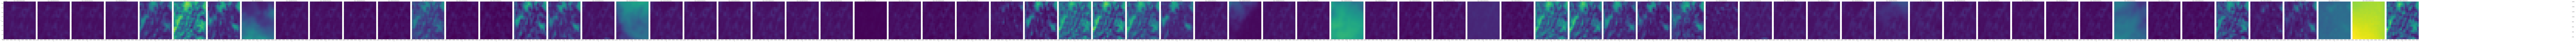

In [74]:
cube.green.plot.imshow(col="time", size=8, aspect=1)

[['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2']]

Search Landsat 7

In [ ]:
#collection = ['landsat-ot-c2-l2'] # ls8
#collection = ['landsat-etm-c2-l2'] # ls7
#collection = ['landsat-tm-c2-l2'] # ls4-5 
#collection = ['sentinel-2-c1-l2a']
collection = ['landsat-ot-c2-l2','landsat-etm-c2-l2','landsat-tm-c2-l2']
#collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2', 'sentinel-2-c1-l2a']

search_ls = catalog.search(collections=collection,
                           bbox=bbox,
                           datetime=[start, end],
                           query=query)
items_ls = list(search_ls.get_items())
print(f'Found {len(items_ls)} Scenes') 
# for item in items_ls:
#     print(item.id, item.collection_id)

In [150]:
collection = ['landsat-ot-c2-l2','landsat-etm-c2-l2','landsat-tm-c2-l2']
items_ls = sd_meta.apply(query_stac, axis=1)

Name: Anterselva_di_Mezzo_Osservatore, Items: 1007
Name: Bronzolo_Osservatore, Items: 698
Name: Diga_di_Gioveretto_Osservatore, Items: 814
Name: Diga_di_Neves_Osservatore, Items: 928
Name: Diga_di_Valdaora_Osservatore, Items: 1070
Name: Diga_di_Vizze_Osservatore, Items: 931
Name: Diga_di_Zoccolo_Osservatore, Items: 1082
Name: Fie_allo_Sciliar_Osservatore, Items: 937
Name: Fontana_Bianca, Items: 878
Name: Fortezza_Osservatore, Items: 931
Name: Fundres_Osservatore, Items: 931
Name: La_Villa_in_Badia_Osservatore, Items: 985
Name: Lago_Verde_Osservatore, Items: 839
Name: Lazfons_Osservatore, Items: 937
Name: Longiaru_Osservatore, Items: 998
Name: Luson_Osservatore, Items: 935
Name: Maia_Alta_Osservatore, Items: 959
Name: Mazia_Osservatore, Items: 863
Name: Melago_Osservatore, Items: 861
Name: Meltina_Osservatore, Items: 939
Name: Molini_di_Tures_Osservatore, Items: 1040
Name: Ortisei_Osservatore, Items: 938
Name: Pennes_Osservatore, Items: 982
Name: Plata_Osservatore, Items: 1011
Name: Rac

In [ ]:
items_ls

In [91]:
cube_ls = odc_stac.load(items_ls.iloc[0],
                        geopolygon=sd_meta.iloc[0].geometry, 
                        groupby='solar_day',
                        #bbox=sd_meta.iloc[1:2],
                        #chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
                        #anchor=geobox.AnchorEnum.FLOATING,  # preserve original pixel grid
                        bands=bands
)
cube_ls

<xarray.Dataset>
Dimensions:      (y: 8, x: 8, time: 118)
Coordinates:
  * y            (y) float64 5.194e+06 5.194e+06 ... 5.194e+06 5.194e+06
  * x            (x) float64 7.362e+05 7.363e+05 ... 7.364e+05 7.365e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2013-04-13T10:00:09.937583 ... 2019-12...
Data variables:
    swir16       (time, y, x) uint16 17149 18253 17871 17568 ... 8721 8100 6899
    green        (time, y, x) uint16 10148 11537 11289 ... 29052 30119 14284

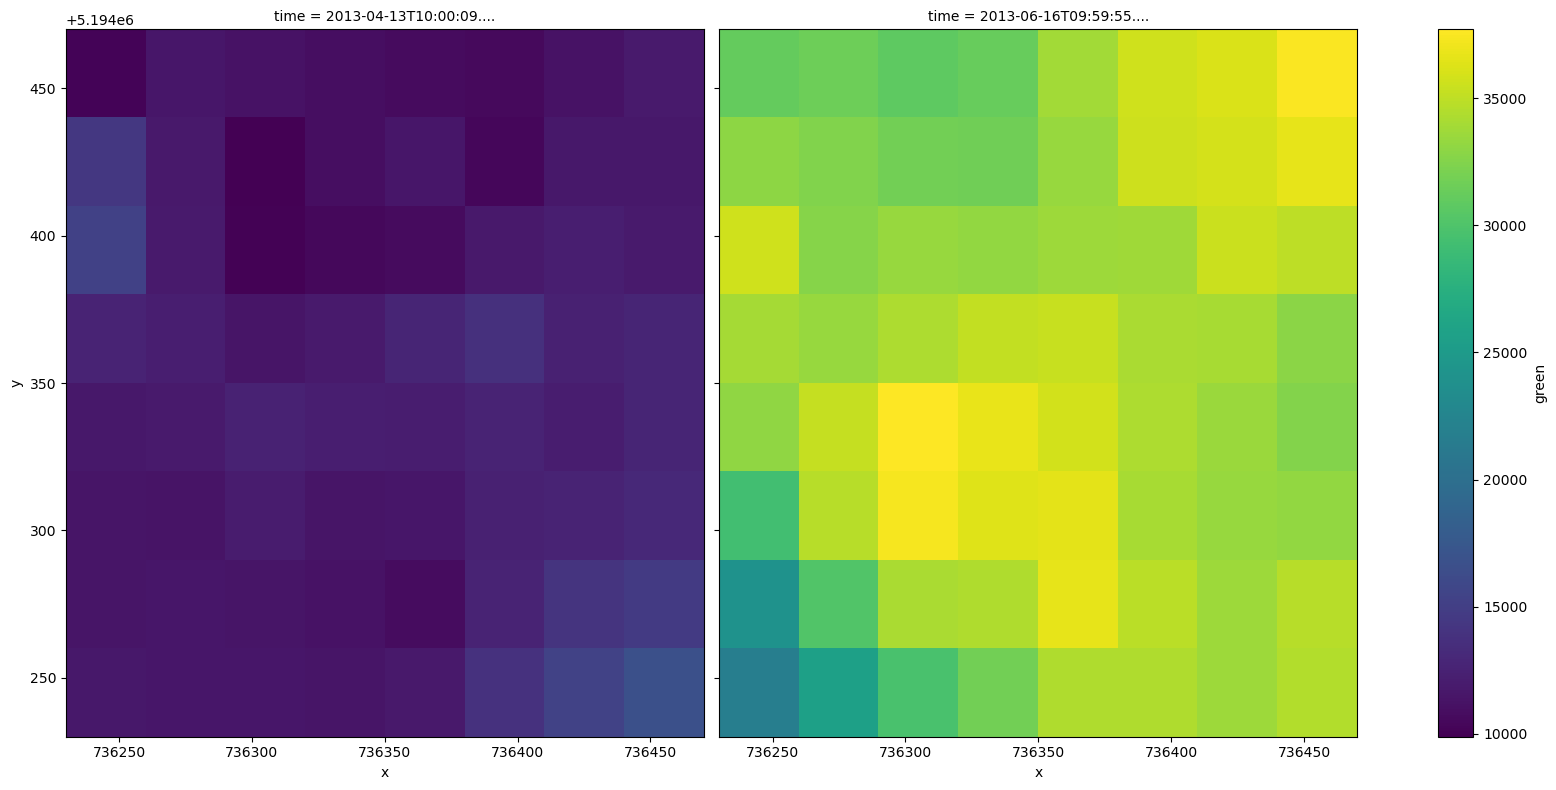

In [88]:
cube_ls.green.isel(time=slice(None, 2)).plot.imshow(col="time", size=8, aspect=1)

# Visualize the covered area

In [49]:
map = folium.Map()
layer_control = folium.LayerControl(position='topright', collapsed=True)
fullscreen = folium_plugins.Fullscreen()
style_s2 = {'fillColor': '#00000000', "color": "#ff0000", "weight": 1}
style_ls = {'fillColor': '#00000000', "color": "#0000ff", "weight": 1}

footprints_s2 = folium.GeoJson(
    gpd.GeoDataFrame.from_features([item.to_dict() for item in items_s2]).to_json(),
    name='S2 footprints',
    style_function=lambda x: style_s2,
    control=True
)

# footprints_ls = folium.GeoJson(
#     gpd.GeoDataFrame.from_features([item.to_dict() for item in items_ls]).to_json(),
#     name='LS footprints',
#     style_function=lambda x: style_ls,
#     control=True
# )

from shapely.geometry import box
bbox_map = box(*bbox)
bbox_map = gpd.GeoDataFrame({"geometry": [bbox_map]})
bbox_map = bbox_map.to_json()
bbox_map = folium.GeoJson(
    bbox_map,
    name='Bbox Search',
    control=True
)    

bbox_map.add_to(map)
footprints_s2.add_to(map)
#footprints_ls.add_to(map)
layer_control.add_to(map)
fullscreen.add_to(map)
map.fit_bounds(map.get_bounds())
map

# Load the STAC items into xarray

Define some general settings for the data cubes and the dask cluster.

In [23]:
# data cube settings
bands_s2 = ['nir', 'red']
bands_ls = ['nir08', 'red'] # unfortunately they don't have the same band aliases.
resolution = 60

# dask settings
dir_out = '~/xarray-dask-tutorial'
dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
dask_chunksize=1024
dask_threads = 1

Load the S2 stack and calculate NDVI

In [26]:
cube_s2 = odc_stac.load(
    items_s2,
    bands=bands_s2,
    resolution=resolution,
    bbox=bbox,
    groupby='solar_day',
    chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
    anchor=geobox.AnchorEnum.FLOATING  # preserve original pixel grid
)
# temporal chunking
cube_s2 = cube_s2.chunk(chunks={'time': -1})

# calc ndvi
cube_s2["ndvi"]=(cube_s2.nir - cube_s2.red)/(cube_s2.nir + cube_s2.red)

# write CF-compliant CRS representation
#cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)
cube_s2

<xarray.Dataset>
Dimensions:      (y: 21, x: 29, time: 28)
Coordinates:
  * y            (y) float64 5.382e+06 5.382e+06 ... 5.381e+06 5.381e+06
  * x            (x) float64 6.924e+05 6.925e+05 ... 6.941e+05 6.941e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2023-02-07T10:11:09.024000 ... 2023-12...
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(28, 21, 29), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(28, 21, 29), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(28, 21, 29), meta=np.ndarray>

Load the LS cube and calculate NDVI.

In [27]:
cube_ls = odc_stac.load(
    items_ls,
    bands=bands_ls,
    resolution=resolution,
    bbox=bbox,
    groupby='solar_day',
    chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
    anchor=geobox.AnchorEnum.FLOATING  # preserve original pixel grid
)
# temporal chunking
cube_ls = cube_ls.chunk(chunks={'time': -1})

# calc ndvi
cube_ls["ndvi"]=(cube_ls.nir08 - cube_ls.red)/(cube_ls.nir08 + cube_ls.red)

# write CF-compliant CRS representation
#cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)
cube_ls

<xarray.Dataset>
Dimensions:      (y: 21, x: 29, time: 10)
Coordinates:
  * y            (y) float64 5.382e+06 5.382e+06 ... 5.381e+06 5.381e+06
  * x            (x) float64 6.924e+05 6.925e+05 ... 6.941e+05 6.941e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2023-04-06T07:57:16.713956 ... 2023-10...
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(10, 21, 29), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(10, 21, 29), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(10, 21, 29), meta=np.ndarray>

In [31]:
# combine the two datacubes into one only keeping the ndvi band
#s2 = cube_s2.compute()
s2

<xarray.Dataset>
Dimensions:      (y: 21, x: 29, time: 28)
Coordinates:
  * y            (y) float64 5.382e+06 5.382e+06 ... 5.381e+06 5.381e+06
  * x            (x) float64 6.924e+05 6.925e+05 ... 6.941e+05 6.941e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2023-02-07T10:11:09.024000 ... 2023-12...
Data variables:
    nir          (time, y, x) uint16 4592 5088 4485 4364 ... 3002 3796 3996 2393
    red          (time, y, x) uint16 2020 1520 1728 1733 ... 1617 1505 1487 1392
    ndvi         (time, y, x) float64 0.389 0.54 0.4437 ... 0.4322 0.4576 0.2645

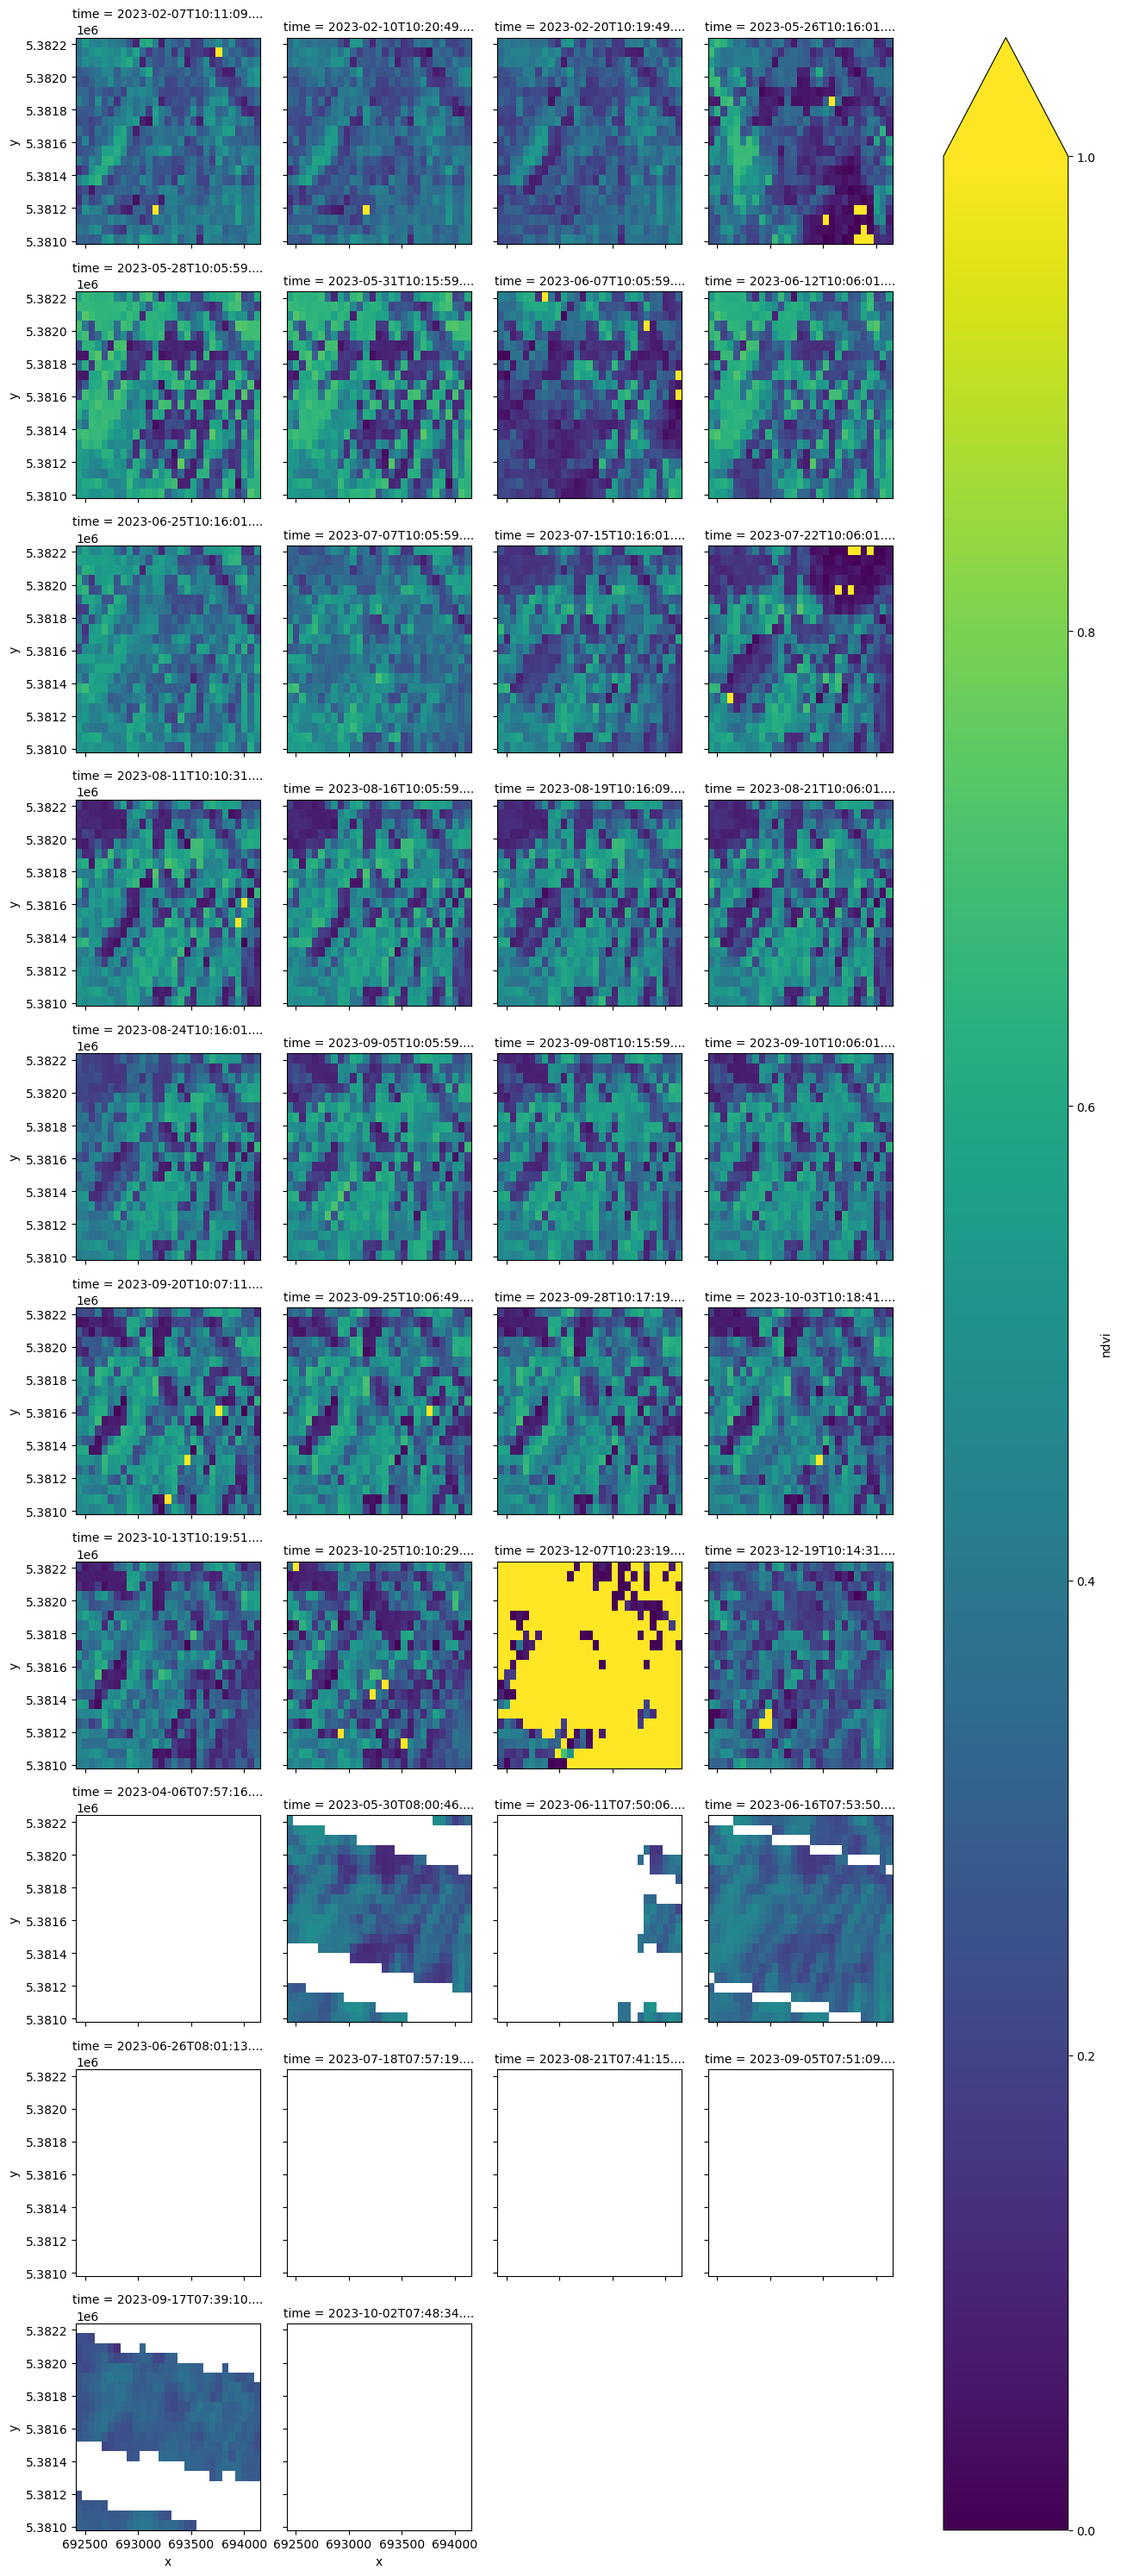

In [54]:
#s2.ndvi.isel(time=15).plot.imshow(vmin=0, vmax=1)
cube_ndvi = xarray.concat([cube_s2.ndvi, cube_ls.ndvi], dim='time')
#cube_ndvi
g_simple = cube_ndvi.plot(x="x", y="y", col="time", col_wrap=4, vmin=0, vmax=1)

AttributeError: Line2D.set() got an unexpected keyword argument 'vmin'

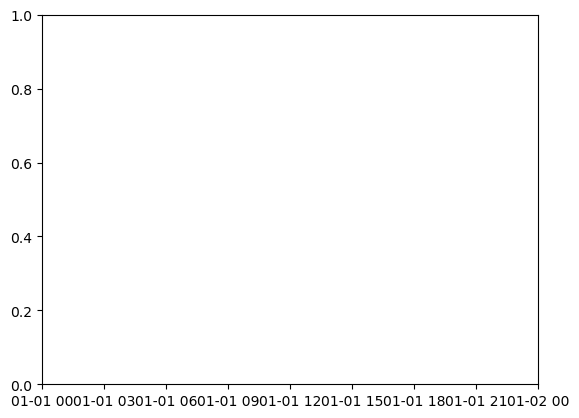

In [70]:
# time series s2
#cube_s2.ndvi.median(dim=['x', 'y']).plot.line(marker='o')
# time series ls
#cube_ls.ndvi.median(dim=['x', 'y']).plot.line(marker='o')
# time series combined
cube_ndvi.median(dim=['x', 'y']).plot.line(marker='o', vmin=0, vmax=0.8) # probably have to rechunk cube_ndvi, to mix s2 and ls time steps

# Define the computation

In [8]:
median = (cube.quantile(0.5, dim='time', skipna=True, keep_attrs=True)
          .rename({b: f'{b}_median' for b in list(cube.keys())}))
median

<xarray.Dataset>
Dimensions:      (y: 1830, x: 1830)
Coordinates:
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
    quantile     float64 0.5
Data variables:
    nir_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    red_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    ndvi_median  (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>

# Start the dask client
Here we are starting the dask client for scaling the computation to the available resources.  
Once started, a link to the dask dashboard will be shown which will display details on the dask computation status.

In [9]:
host = os.getenv('host')
jl_port = os.getenv('port')
#create to URL to point to the jupyter-server-proxy
dask_url = f'https://portal.terrabyte.lrz.de/node/{host}/{jl_port}'+'/proxy/{port}/status'
#dask will insert the final port choosen by the Cluster 

dask.config.set({'temporary_directory': dask_tmpdir,
                 'distributed.dashboard.link': dask_url})

#some settings to increase network timeouts and allow the dashboard to plot larger graphs
dask.config.set({'distributed.comm.timeouts.tcp': '180s',
                 'distributed.comm.timeouts.connect': '120s',
                 'distributed.dashboard.graph-max-items': 55000,
                 'distributed.deploy.lost-worker-timeout': '90s',
                 'distributed.scheduler.allowed-failures': 180,
                 })
#we set the dashboard address for dask to choose a free random port, so there is no error with multiple dasks running on same node 
client = Client(threads_per_worker=dask_threads, dashboard_address="127.0.0.1:0")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,Workers: 16
Total threads: 16,Total memory: 50.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34585,Workers: 16
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,Total threads: 16
Started: Just now,Total memory: 50.00 GiB
Comm: tcp://127.0.0.1:33771,Total threads: 1
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/43495/status,Memory: 3.12 GiB
Nanny: tcp://127.0.0.1:44839,


# Start the computation
Here the actual computation is started and the result written to the output file.  
Check the dask dashboard for computation progress.

In [10]:
%%time
#ignore invalid value encountered in divide warning (ndvi divide by zero)
delayed = median.to_zarr(filename, mode='w', compute=False, consolidated=True)
dask.compute(delayed)

/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 41.1 s, sys: 3.55 s, total: 44.6 s
Wall time: 2min 35s


(None,)

In [11]:
client.cluster.close()
time.sleep(5)
client.close()

# Load and Visualize the result from File

In [12]:
result = xarray.open_zarr(filename)
result

<xarray.Dataset>
Dimensions:      (y: 1830, x: 1830)
Coordinates:
    quantile     float64 ...
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    ndvi_median  (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    nir_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    red_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>

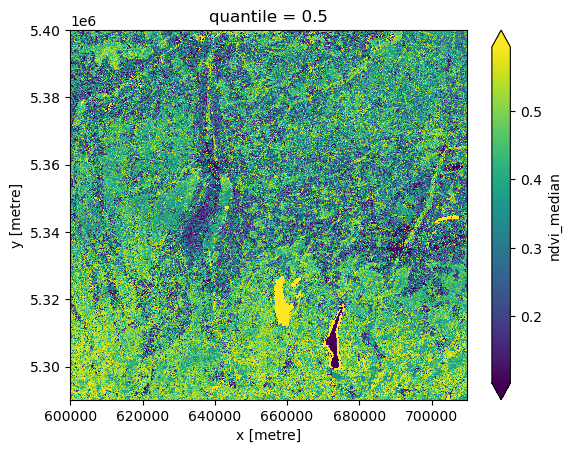

In [13]:
result.ndvi_median.plot(robust=True)

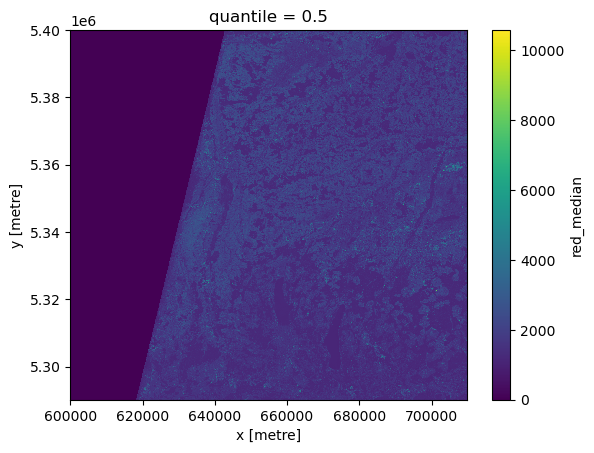

In [14]:
result['red_median'].plot()

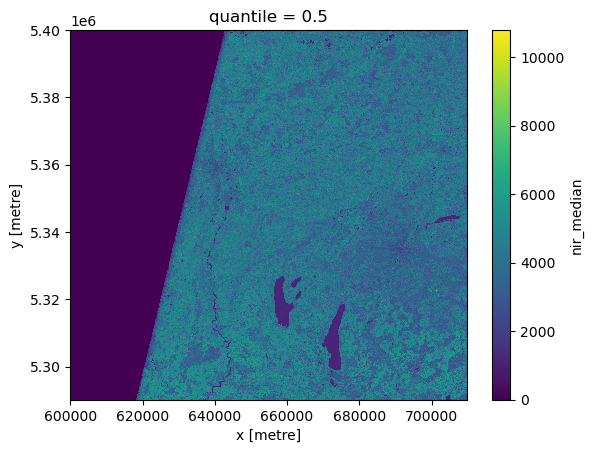

In [16]:
result['nir_median'].plot()